# Notebook on how to check your fMRI data

Authors: Eduarda Centeno
    
The goal is to show how to work with matrices, how to plot and what to check.


#### Let's start with the necessary packages for the following computations:

    Requirements: 
    
    - Python: 3.7.3
    - Numpy: 1.16.3
    - Matplotlib: 3.2.1
    - Seaborn: 0.10.1
    - Pandas: 1.0.3
    - JupyterLab: 1.2.0
    
    
    


In [13]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

### Some key tips:

    - You should check if there are NaNs, zeros, infs in the matrix.
    - If using AAL -- work only with the 78 first regions.
    - We usually remove regions that have less than 5 voxels of signal (e.g. orbitofrontal regions)
    - If working with matrices of the same size (might differ if removing regions because of a tumor, for example), one can average them out and plot:
        - Correlation strength distribution
        - Check correlations for the Default Mode Network
    - Connectivity matrix should show 3 diagonals. Usually, there are clusters around the central diagonal that indicate modularity, whereas the 2 other diagonals indicate inter-hemispheric connections
    - Lower connectivity values can indicate a lower signal originally.
    - We also work with normalized matrices for final analysis (Absolutize > Z-score > Rescale)

In [14]:
# Import the example matrix
matfinal = np.genfromtxt('randMat.txt')

# Import a list of region names
names = [line.rstrip('\n') for line in open('./AREAS.txt')]

# Define pallete that will be used
pallete = sns.color_palette("colorblind") # option 2: 'coolwarm'

In [15]:
# Checking if there are NaNs, infs, zeros.
print('Matrix has Infs: ' + str(np.isinf(matfinal).any()))
print('Matrix has NaNs: ' + str(np.isnan(matfinal).any()))
print('Matrix has Zeros: ' + str((matfinal == 0).any()))

Matrix has Infs: False
Matrix has NaNs: True
Matrix has Zeros: False


##### As it is possible to see, the matrix has NaNs, this will be evident by plotting a heatmap / connectivity matrix below as blank lines:

(78.0, 0.0)

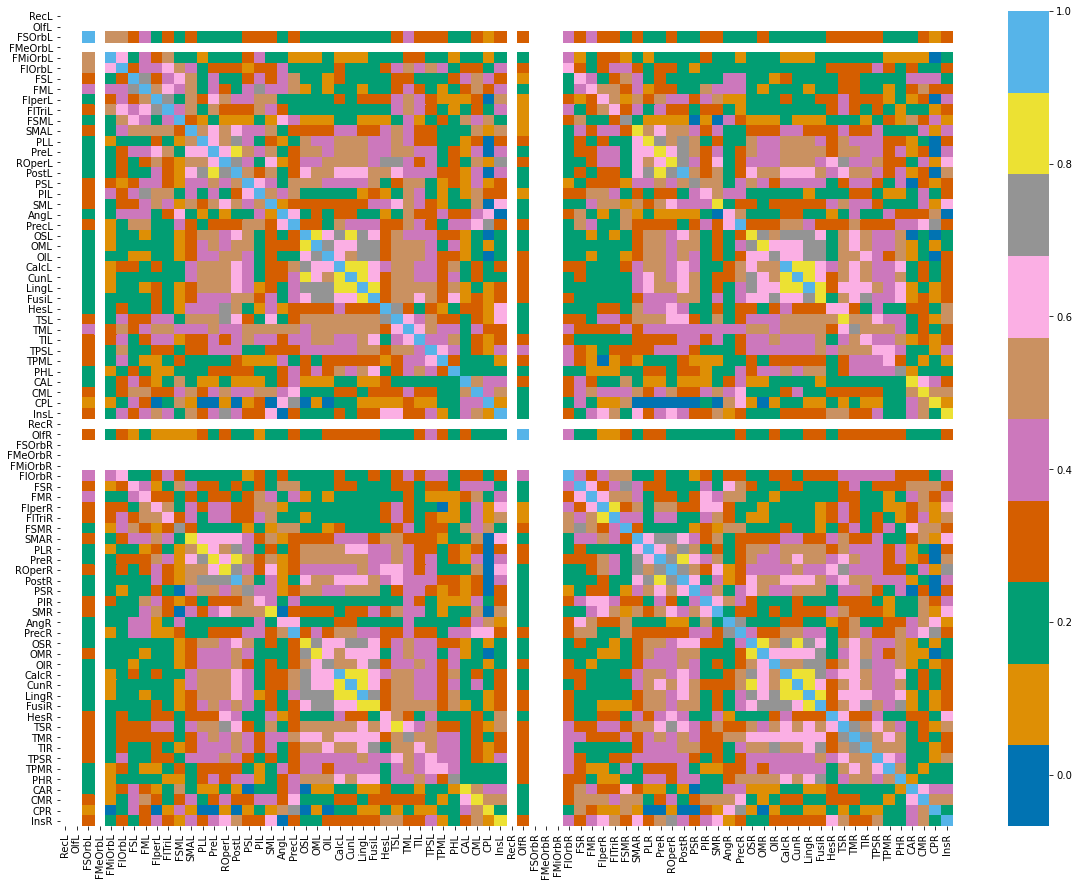

In [16]:
# Visualize entire matrix in its raw form
df = pd.DataFrame(matfinal)
plt.figure(figsize=(20,15))
ax = sns.heatmap(df, cmap=pallete, annot=False)
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(df))
ax.set_ylim(len(df), 0)

##### As mentioned above, some regions (usually orbitofrontal - as we can see also in this matrix) might have to be removed do to a lack of signal. One can see these regions here as totally white columns or rows. Thus, it is necessary to remove them.

(71.0, 0.0)

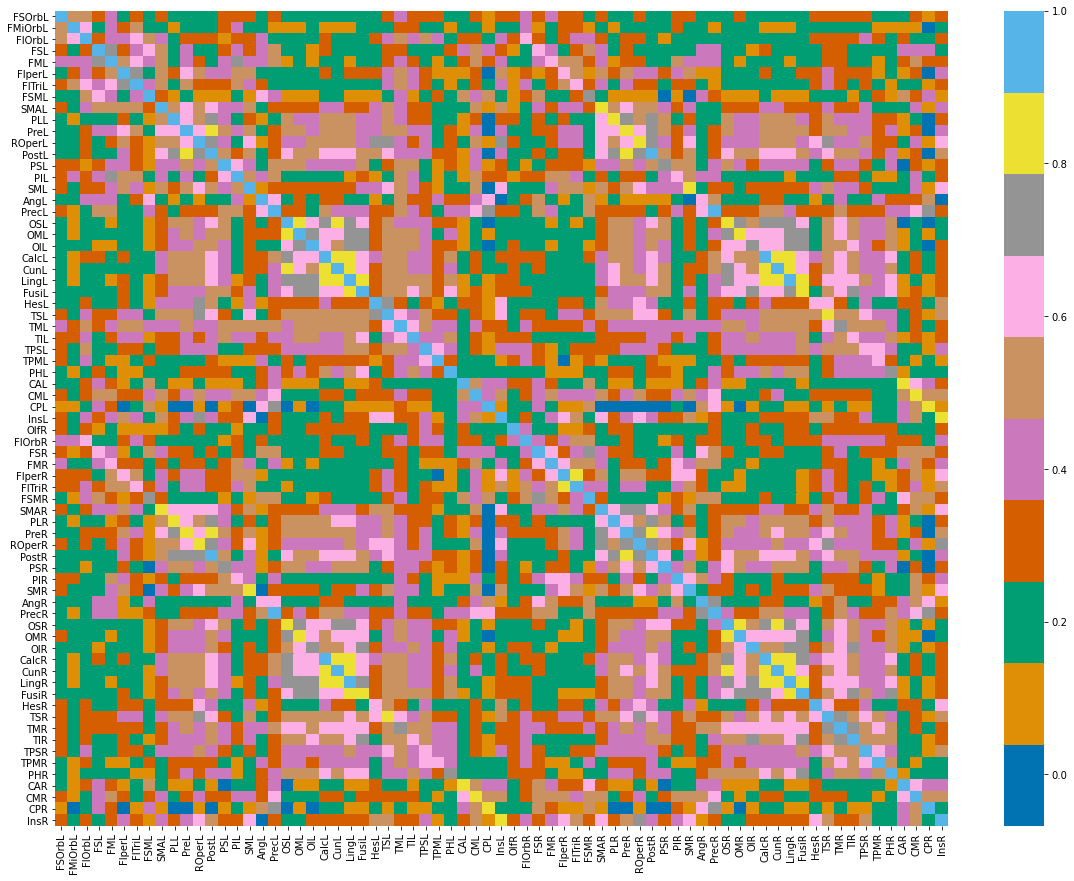

In [17]:
matdropped = df.dropna(axis=1, how='all').dropna(axis=0,how='all').copy()
plt.figure(figsize=(20,15))
ax = sns.heatmap(matdropped, cmap=pallete, annot=False)
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(matdropped))
ax.set_ylim(len(matdropped), 0)

Now, one does not see these blank spaces anymore. One can also check how the matrice will not have NaNs anymore. 
As discussed above, it is possible to see 3 clear diagonals in the matrix. 


##### Now let's plot the connectivity distribution plots.
The distribution of connectivity easily shows whether there are outliers in connectivity values in your matrix, and whether the overall distribution fits with what we expect of fMRI data (i.e. a right-skewed distribution).

[Text(0.5, 0, 'Correlation Values'), Text(0, 0.5, 'Density Frequency')]

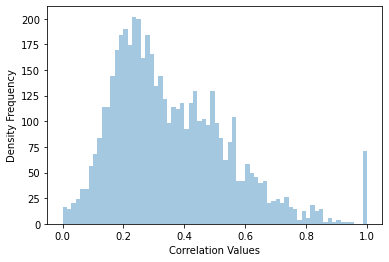

In [18]:
# Connectivity distribution plot
bins=np.arange(np.sqrt(len(np.concatenate(matdropped.values))))
bins = (bins - np.min(bins))/np.ptp(bins)

# Distribution of raw weights
rawdist = sns.distplot(matdropped.values.flatten(), bins=bins, kde=False)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

##### Now let's have a look at the DMN

(24.0, 0.0)

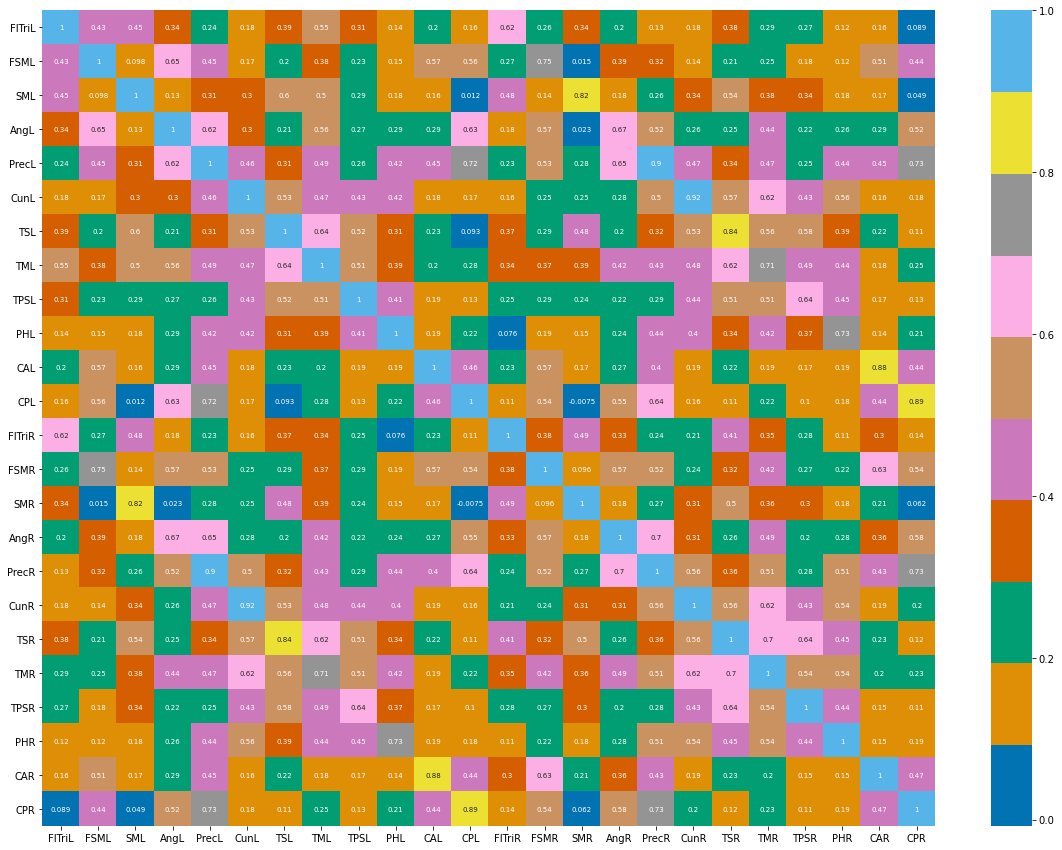

In [19]:
#Checking DMN
regs = np.loadtxt('./yeo_7networks_aal_order.txt', dtype=int)
dmn = np.where(regs==7)[0]
UTDdmn  = list((set(dmn).intersection(matdropped.columns)))
UTDdmn = np.array(UTDdmn) # Update DMN list to fit columns from rescaled matrix

dfDMN = matdropped.filter(UTDdmn, axis=0).filter(UTDdmn, axis=1).copy()
   
plt.figure(figsize=(20,15))
ax = sns.heatmap(dfDMN, cmap=pallete, annot=True, annot_kws = {"size":7})
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(dfDMN))
ax.set_ylim(len(dfDMN), 0)

An area that is usually evaluated to check for DMN connectivity is the precuneus (PrecR or L), and here we can indeed see a strong connection between them. Other than, that the whole diagonal that includes these DMN areas show, overall, strong connectivity. 

##### It is common practice to work with normalized matrices to overcome variability between scans, so now we will do the same as above, but now applying the normalization function.

In [20]:
def normalize(matrix): # Absolutize > Zscore > Rescale 
    """
    This function is supposed to normalize the matrices by first absolutizing it abs();
    Another important step is that we need to send the diagonal to NaN to not skew the mean/std.
    Then we compute a Z-score based on the matrix's mean and std. Taking into consideration that NaNs are present, we will use
    np.nanmean() and np.nanstd(). 
    Finally I rescale the matrix between 0 and 1 according to https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
    
    Arguments:
        matrix = numpy matrix
        
    Output: 
        zscored matrix & rescaled matrix
    """
    
    matrixabs = abs(matrix)
    np.fill_diagonal(matrixabs, np.nan)
    zmatrix = (matrixabs - np.nanmean(matrixabs))/np.nanstd(matrixabs)
    rescaled = (zmatrix - np.nanmin(zmatrix))/(np.nanmax(zmatrix)- np.nanmin(zmatrix))
    return zmatrix, rescaled

In [21]:
def checknorm(matrix, zmatrix, rescaled, pallete=pallete):
    """
    To double-check normalization function.
    
    Arguments:
        matrix = numpy matrix
        zmatrix = zscored version of matrix
        rescaled = rescaled version of matrix
        
    Output: 
        Plots of each matrix and its distribution.
    """
    fig,ax = plt.subplots(2,3, figsize=(25,15))
    sns.heatmap(matrix, cmap=pallete, ax=ax[0,0])
    sns.heatmap(zmatrix, cmap=pallete, ax=ax[0,1])
    sns.heatmap(rescaled, cmap=pallete, ax=ax[0,2])
    ax[0,0].set_ylim(len(matrix),0)
    ax[0,1].set_ylim(len(matrix),0)
    ax[0,2].set_ylim(len(matrix),0)
    sns.distplot(matrix.flatten(), kde=True, ax=ax[1,0])
    ax[1,0].set_xlabel('Raw Weights')
    sns.distplot(zmatrix.flatten(), kde=True, ax=ax[1,1])
    ax[1,1].set_xlabel('Z-Scored Weights')
    sns.distplot(rescaled.flatten(), kde=True, ax=ax[1,2])
    ax[1,2].set_xlabel('Normalized Weights')
    ax[0,0].set_title('Raw Matrix')
    ax[0,1].set_title('Z-Scored Matrix')
    ax[0,2].set_title('Rescaled Matrix')

###### Let's just observe in more detail the normalization process.

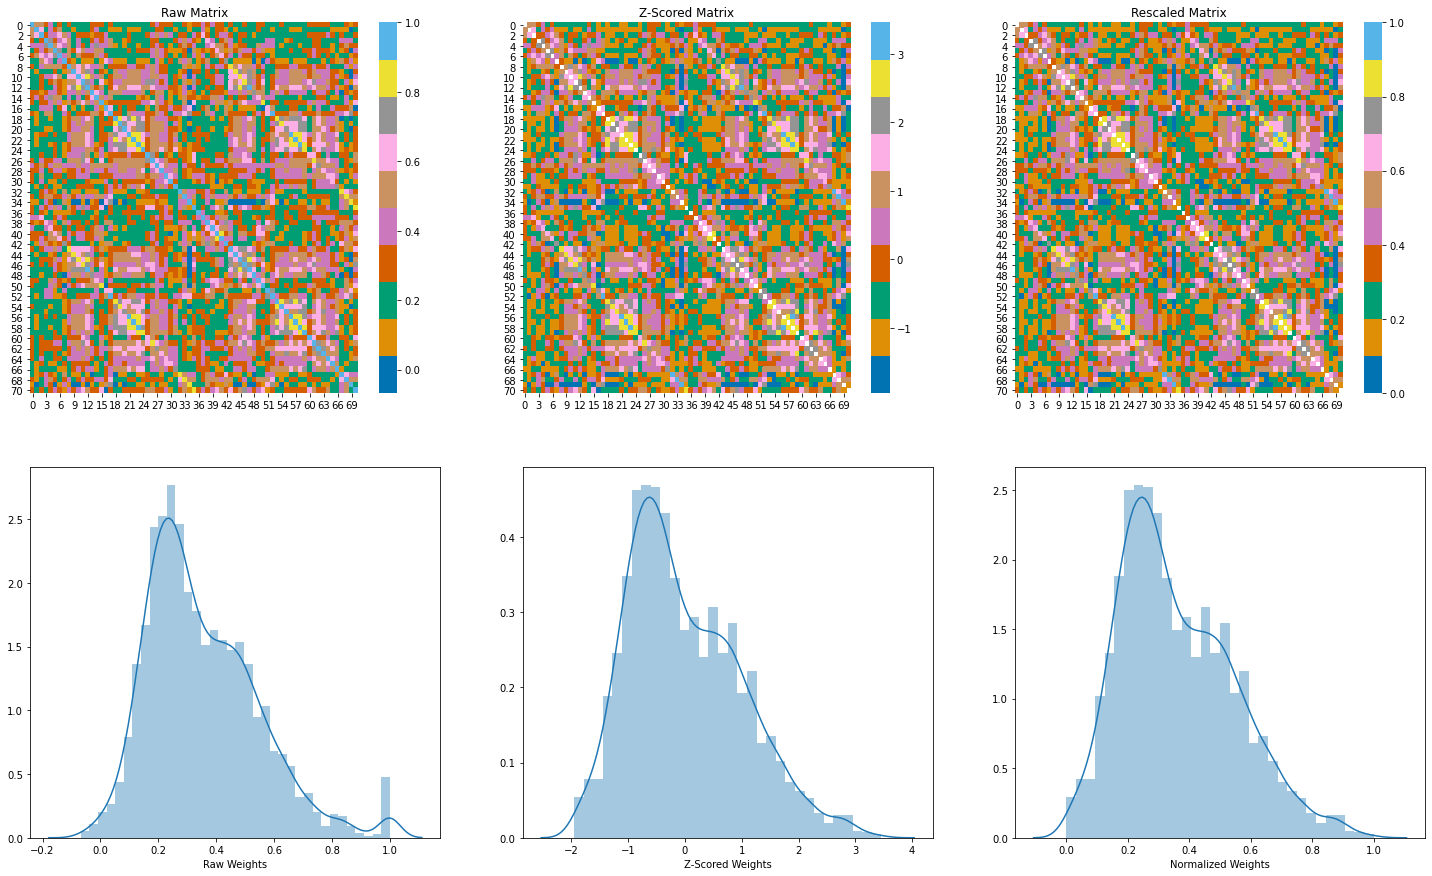

In [22]:
zmatrix, rescaled = normalize(matdropped.values)
checknorm(matdropped.values, zmatrix, rescaled)

(71.0, 0.0)

<Figure size 1800x1080 with 0 Axes>

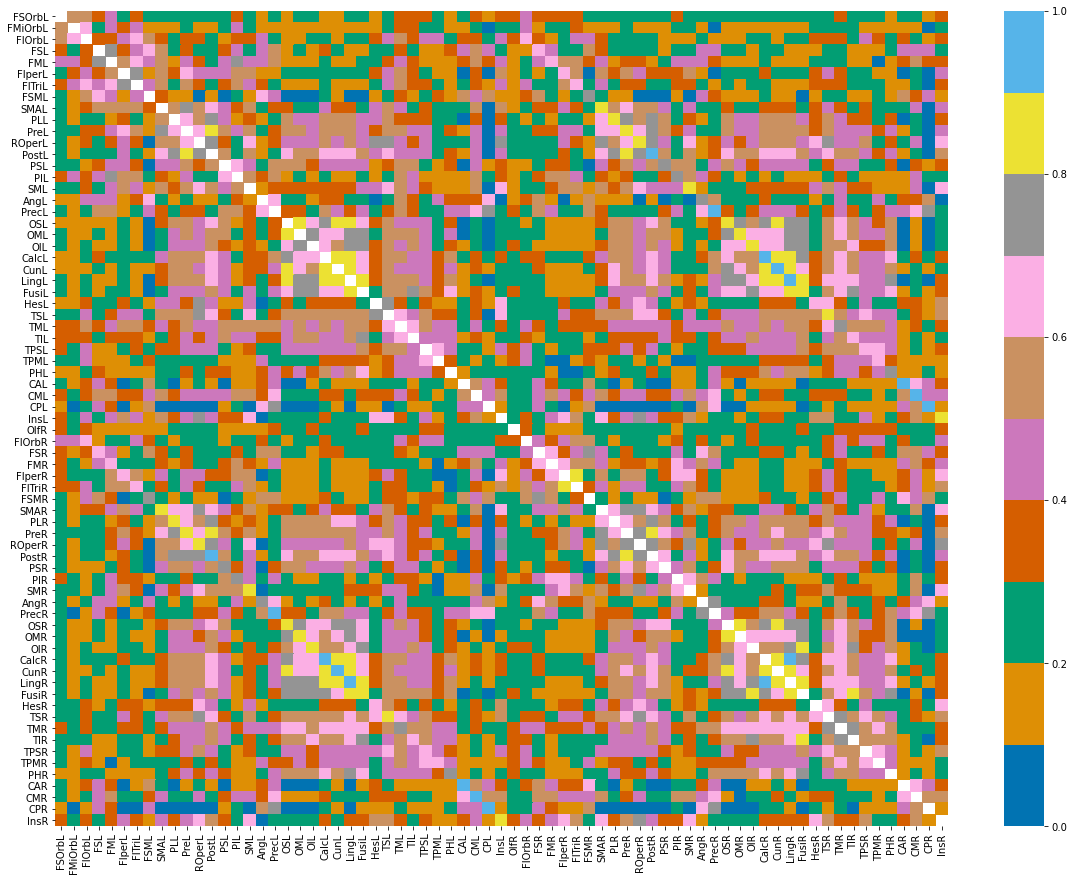

In [23]:
# A 'zoom' NORMALIZED matrix
plt.figure(figsize=(25,15))
df3 = pd.DataFrame(rescaled)
df3.columns = matdropped.columns # Returing correct col/row numbers for proper filtering.
df3.index = df3.columns # Returing correct col/row numbers for proper filtering.

plt.figure(figsize=(20,15))
ax = sns.heatmap(df3, cmap=pallete, annot=False)
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(df3))
ax.set_ylim(len(df3), 0)

(24.0, 0.0)

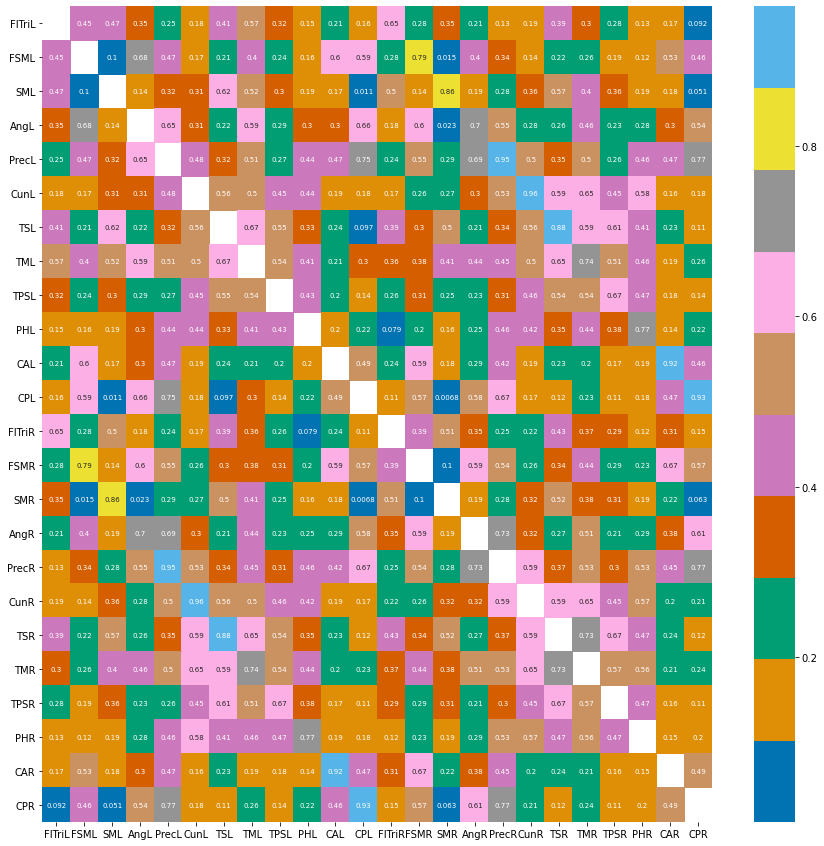

In [24]:
#Checking DMN in NORMALIZED matrix

dfDMN2 = df3.filter(UTDdmn, axis=0).filter(UTDdmn, axis=1).copy()
   
plt.figure(figsize=(15,15))
ax = sns.heatmap(dfDMN2, cmap=pallete, annot=True, annot_kws = {"size":7})
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(dfDMN2))
ax.set_ylim(len(dfDMN2), 0)